In [1]:
import pandas as pd



In [2]:
import os
#from dotenv import load_dotenv # remove for github

In [3]:
#load_dotenv() #remove for github
kaggle_username = os.getenv('KAGGLE_USERNAME')
kaggle_key = os.getenv('KAGGLE_KEY')

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key


In [4]:
! rm datasets/player_valuations.csv
! rm datasets/appearances.csv
! rm datasets/players.csv
! rm datasets/club_games.csv
! rm datasets/game_lineups.csv
! rm datasets/games.csv

rm: datasets/player_valuations.csv: No such file or directory
rm: datasets/appearances.csv: No such file or directory
rm: datasets/players.csv: No such file or directory
rm: datasets/club_games.csv: No such file or directory
rm: datasets/game_lineups.csv: No such file or directory
rm: datasets/games.csv: No such file or directory


In [5]:
! kaggle datasets download -d davidcariboo/player-scores -f player_valuations.csv -p datasets
! kaggle datasets download -d davidcariboo/player-scores -f appearances.csv -p datasets
! kaggle datasets download -d davidcariboo/player-scores -f players.csv -p datasets
! kaggle datasets download -d davidcariboo/player-scores -f club_games.csv -p datasets
! kaggle datasets download -d davidcariboo/player-scores -f game_lineups.csv -p datasets
! kaggle datasets download -d davidcariboo/player-scores -f games.csv -p datasets

! unzip datasets/player_valuations.csv.zip -d datasets
! unzip datasets/appearances.csv.zip -d datasets
! unzip datasets/players.csv.zip -d datasets
! unzip datasets/club_games.csv.zip -d datasets
! unzip datasets/game_lineups.csv.zip -d datasets
! unzip datasets/games.csv.zip -d datasets

! rm datasets/player_valuations.csv.zip
! rm datasets/appearances.csv.zip
! rm datasets/players.csv.zip
! rm datasets/club_games.csv.zip
! rm datasets/game_lineups.csv.zip
! rm datasets/games.csv.zip



 78%|█████████████████████████████▌        | 3.00M/3.86M [00:00<00:00, 4.36MB/s]
100%|██████████████████████████████████████| 3.86M/3.86M [00:00<00:00, 4.39MB/s]
 99%|█████████████████████████████████████▌| 32.0M/32.4M [00:03<00:00, 12.7MB/s]
100%|██████████████████████████████████████| 32.4M/32.4M [00:03<00:00, 9.43MB/s]
 84%|███████████████████████████████▉      | 2.00M/2.38M [00:00<00:00, 3.07MB/s]
100%|██████████████████████████████████████| 2.38M/2.38M [00:00<00:00, 3.04MB/s]
 81%|██████████████████████████████▋       | 2.00M/2.48M [00:00<00:00, 2.51MB/s]
100%|██████████████████████████████████████| 2.48M/2.48M [00:00<00:00, 2.77MB/s]
 85%|████████████████████████████████▎     | 4.00M/4.70M [00:00<00:00, 5.24MB/s]
100%|██████████████████████████████████████| 4.70M/4.70M [00:00<00:00, 4.96MB/s]
 64%|████████████████████████▎             | 3.00M/4.69M [00:00<00:00, 4.70MB/s]
100%|██████████████████████████████████████| 4.69M/4.69M [00:00<00:00, 5.64MB/s]
Archive:  datasets/player_va

## VALUATIONS

In [6]:
# Read valuations
valuations_path = 'datasets/player_valuations.csv'

# Read the CSV file into a pandas DataFrame
df_val = pd.read_csv(valuations_path)

#drop unesseccary columns
df_val = df_val.drop(columns=["datetime", "dateweek"])


## CONSTANTS

In [7]:
#Get latest season end year
latest_date = df_val['date'].max()
latest_year = int(latest_date[0:4])
latest_year

MONTH_START = "-08-10"
MONTH_END = "-06-10"

## PLAYER STATS

In [8]:
# Read stats
"""
Columns
appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
"""
stats_path = 'datasets/appearances.csv'

# Read the CSV file into a pandas DataFrame
df_stats = pd.read_csv(stats_path)

#drop unesseccary columns
#TBD

## CATEGORICAL DATA

In [9]:
"""
CATEGORICAL DATA HANDLING
Columns
player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
"""

# Read player categorical data
categorical_path = 'datasets/players.csv'

df_categorical = pd.read_csv(categorical_path)

#drop redundant columns
#comment: dropping sub-position as all players only have one
df_cat = df_categorical.drop(
    columns=[
        "first_name", "last_name", "name", "player_code", "city_of_birth", "image_url", "url", "highest_market_value_in_eur", "current_club_name",
        "agent_name", "current_club_domestic_competition_id", "market_value_in_eur", "current_club_domestic_competition_id", "current_club_id", "last_season", "sub_position"
        ])


#Change date of birth to age
df_cat['date_of_birth'] = pd.to_datetime(df_cat['date_of_birth'])
def calculate_age(birthdate):
    today = pd.to_datetime('today')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

df_cat['age'] = df_cat['date_of_birth'].apply(calculate_age)

#date of birth now redundant
df_cat = df_cat.drop(columns=["date_of_birth"])


# Fill NaN values in 'height_in_cm' with the mean
mean_value = df_cat['height_in_cm'].mean()
df_cat['height_in_cm'].fillna(mean_value, inplace=True)

#Fill NaN values in col Foot with 'right'
most_frequent_value = df_cat['foot'].mode().iloc[0]
df_cat['foot'].fillna(most_frequent_value, inplace=True)

## CLUB GAMES

In [10]:
"""
Club games data handling
Columns: game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
"""

# Read player categorical data
club_games_path = 'datasets/club_games.csv'
game_lineups_path = 'datasets/game_lineups.csv'
games_path = 'datasets/games.csv'


df_club_games = pd.read_csv(club_games_path)
df_game_lineups = pd.read_csv(game_lineups_path)
df_games = pd.read_csv(games_path)


# Use boolean indexing to filter the DataFrame
game_ids_last_season = df_games[(df_games['date'] >= str(latest_year-1) + MONTH_START) & (df_games['date'] <= str(latest_year) + MONTH_END)]

# Get the game_id values for the filtered DataFrame
game_ids_in_range = game_ids_last_season['game_id'].tolist()

df_club_games_last_season = df_club_games[df_club_games['game_id'].isin(game_ids_in_range)]
df_game_line_ups_last_season = df_game_lineups[df_game_lineups['game_id'].isin(game_ids_in_range)]



df_club_games_last_season

/var/folders/np/5mm2p41j3015kfgd1xftmc1c0000gn/T/ipykernel_2465/2596554935.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_game_lineups = pd.read_csv(game_lineups_path)


,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
3524,3825466,418,2,NaN,Carlo Ancelotti,24,0,NaN,Oliver Glasner,Home,1
3529,3828437,678,1,3.0,Uwe Rösler,369,0,10.0,Freyr Alexandersson,Home,1
3530,3828449,2414,2,6.0,Jens Berthel Askou,678,1,4.0,Uwe Rösler,Home,1
3531,3828459,865,0,8.0,Albert Capellas,1053,2,10.0,Lars Friis,Home,0
3532,3828483,2414,0,8.0,Jens Berthel Askou,1053,0,11.0,Erik Hamrén,Home,0
...,...,...,...,...,...,...,...,...,...,...,...
130864,4072488,36,3,3.0,NaN,7775,0,19.0,NaN,Away,1
130865,4072493,7775,0,19.0,NaN,589,3,12.0,NaN,Away,0
130866,4080529,46,2,NaN,Simone Inzaghi,430,1,NaN,Vincenzo Italiano,Away,1
131083,4001330,131,3,NaN,Xavi,418,1,NaN,Carlo Ancelotti,Away,1


## EDA / DATA HANDLING

Fix contract_expiration

In [11]:
#Change contract expiration date to see how many months they have left at end of season
df_cat['contract_expiration_date'] = pd.to_datetime(df_cat['contract_expiration_date'])

current_date = pd.to_datetime(str(latest_year) + MONTH_END) #get latest date we are looking at

# Calculate the difference in months between the contract expiration date and the current date
# Calculate the difference in days first
df_cat['days_left'] = (df_cat['contract_expiration_date'] - current_date).dt.days.fillna(0)

# Convert days to months by dividing by the average number of days per month
# The average number of days in a month is approximately 30.44
df_cat['months_left'] = df_cat['days_left'] / 30.44

# Optional: If you want to round to the nearest whole number
df_cat['months_left'] = df_cat['months_left'].round().astype(int)

#contract expiration now redundant
df_cat = df_cat.drop(columns=["contract_expiration_date", "days_left"])

# Set negative values to zero because there will be some outgoing contracts at end of seasons
df_cat['months_left'] = df_cat['months_left'].clip(lower=0)

Only use last season and top 5 leagues in the world

In [12]:
#Select only specific leagues
competition_column = 'player_club_domestic_competition_id'
competitions = ["IT1", "GB1", "FR1", "L1", "ES1"]

#Take values from only last season
date_column = "date"
max_date_last_season = str(latest_year) + MONTH_END
min_date_last_season = str(latest_year-1) + MONTH_START

# Create a new DataFrame containing only rows where the 'column_name' matches the 'desired_value'
df_val_last_season = df_val[(df_val[competition_column].isin(competitions)) 
                                 & (df_val[date_column] >= min_date_last_season)
                                 & (df_val[date_column] <= max_date_last_season)]

df_stats_last_season = df_stats[(df_stats[date_column] >= min_date_last_season)
                                 & (df_stats[date_column] <= max_date_last_season)]

#Sort based on date
df_sorted = df_val_last_season.sort_values(by=['player_id', 'date'], ascending=[True, False])

# Drop duplicates, keeping the first entry for each 'playerID'
df_latest_valuations_last_season = df_sorted.drop_duplicates(subset='player_id', keep='first')

Select club game wins last season only

In [13]:
#aggregate stats for last season
df_club_games_last_season['clean_sheets'] = (df_club_games_last_season['opponent_goals'] == 0).astype(int)

df_aggregated_club_games= df_club_games_last_season.groupby('club_id').agg({
    'own_goals': 'sum',
    'opponent_goals': 'sum',
    'is_win': 'sum',
    'clean_sheets': 'sum'
}).reset_index()


df_aggregated_club_games['current_club_id'] = df_aggregated_club_games['club_id']

df_aggregated_club_games = df_aggregated_club_games.drop(columns=["club_id"])


/var/folders/np/5mm2p41j3015kfgd1xftmc1c0000gn/T/ipykernel_2465/931433857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_club_games_last_season['clean_sheets'] = (df_club_games_last_season['opponent_goals'] == 0).astype(int)


Aggregate stats for each player over the specific season

In [14]:
#aggregate stats for last season
df_aggregated_stats_last_season = df_stats_last_season.groupby('player_id').agg({
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'player_name': 'first' 
}).reset_index()

In [15]:
"""
STATS DATA HANDLING
"""

#df_aggregated_stats_last_season = df_aggregated_stats_last_season.drop(columns=["yellow_cards"])

'\nSTATS DATA HANDLING\n'

Merge all dataframes together

In [16]:
#Merge all dataframes together
df_val_stats_last_season = pd.merge(df_latest_valuations_last_season, df_aggregated_stats_last_season, on='player_id', how='inner')
df_val_stats_cat_last_season = pd.merge(df_val_stats_last_season, df_cat, on='player_id', how="inner")
df_features = pd.merge(df_val_stats_cat_last_season, df_aggregated_club_games, on='current_club_id', how="inner")



## Final columns

In [17]:
df_features

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,...,country_of_citizenship,position,foot,height_in_cm,age,months_left,own_goals,opponent_goals,is_win,clean_sheets
0,3333,2022-11-03,2000000,1237,GB1,3,0,0,2,1238,...,England,Midfield,right,175.0,37.0,13,98,66,23,15
1,43530,2022-11-03,1500000,1237,GB1,0,0,3,1,759,...,England,Midfield,both,172.0,35.0,13,98,66,23,15
2,67063,2022-11-03,8000000,1237,GB1,0,0,7,3,2053,...,England,Attack,right,185.0,33.0,13,98,66,23,15
3,73564,2023-03-16,1000000,1237,GB1,1,0,0,1,1890,...,England,Goalkeeper,right,188.0,33.0,37,98,66,23,15
4,82873,2022-11-03,8000000,1237,GB1,6,0,8,10,3762,...,Germany,Midfield,right,181.0,32.0,25,98,66,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,350,GB1,0,0,0,0,65,...,England,Attack,right,175.0,22.0,49,12,10,4,2
2711,546712,2022-11-14,3500000,350,GB1,3,0,2,1,869,...,Tunisia,Midfield,both,188.0,22.0,37,12,10,4,2
2712,554251,2023-03-27,3500000,350,GB1,1,0,1,1,1716,...,Algeria,Defender,left,176.0,22.0,13,12,10,4,2
2713,663581,2022-11-07,7000000,350,GB1,12,0,1,1,2665,...,Brazil,Midfield,right,187.0,24.0,49,12,10,4,2


Analysis on wether the feature affects the valuation or not

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

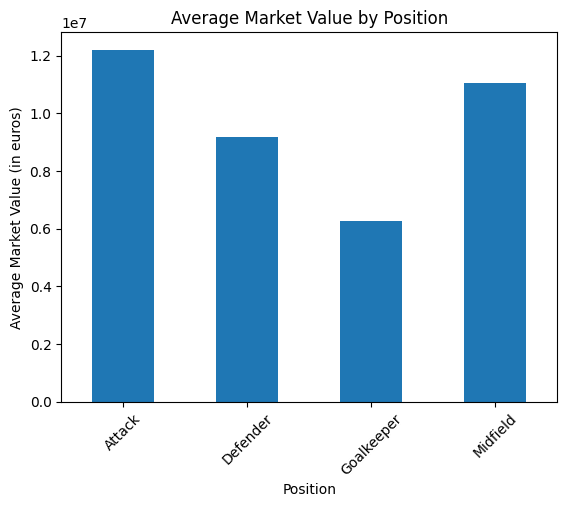

In [19]:
df_features = df_features[df_features['position'] != "Missing"]
grouped_data = df_features.groupby('position')['market_value_in_eur'].mean()

# Plotting
grouped_data.plot(kind='bar')
plt.title('Average Market Value by Position')
plt.xlabel('Position')
plt.ylabel('Average Market Value (in euros)')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability
plt.show()

Positions obviousley affects market value and will be accounted for in the model.

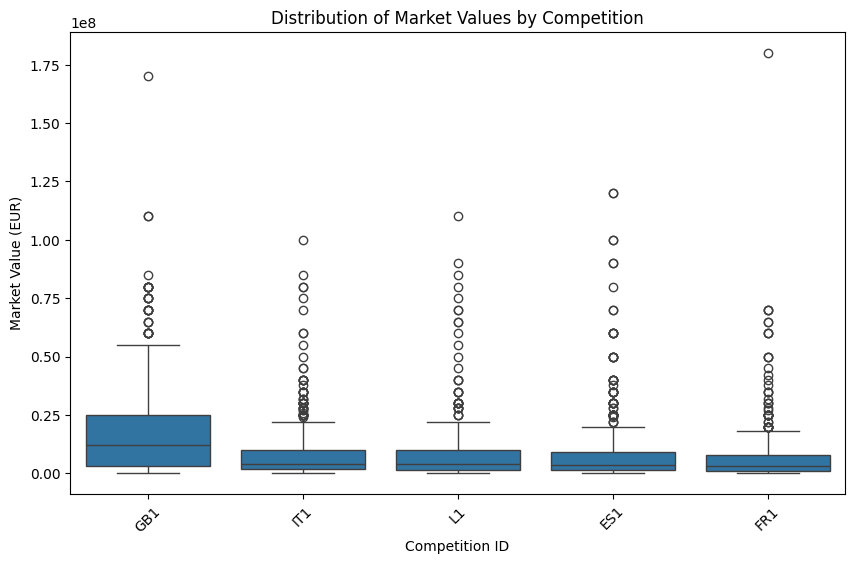

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='player_club_domestic_competition_id', y='market_value_in_eur', data=df_features)

plt.xlabel('Competition ID')
plt.ylabel('Market Value (EUR)')
plt.title('Distribution of Market Values by Competition')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability

plt.show()

GB1 has a relatively wide interquartile range, indicating a larger variation in market values compared to other competitions.
All competitions have outliers above the upper whisker, indicating some players with market values significantly higher than the general population within those competitions.
The median line within each box can give you an idea of the central tendency of market values within each competition.

Which league the player plays in is therefore relevant for the market value.

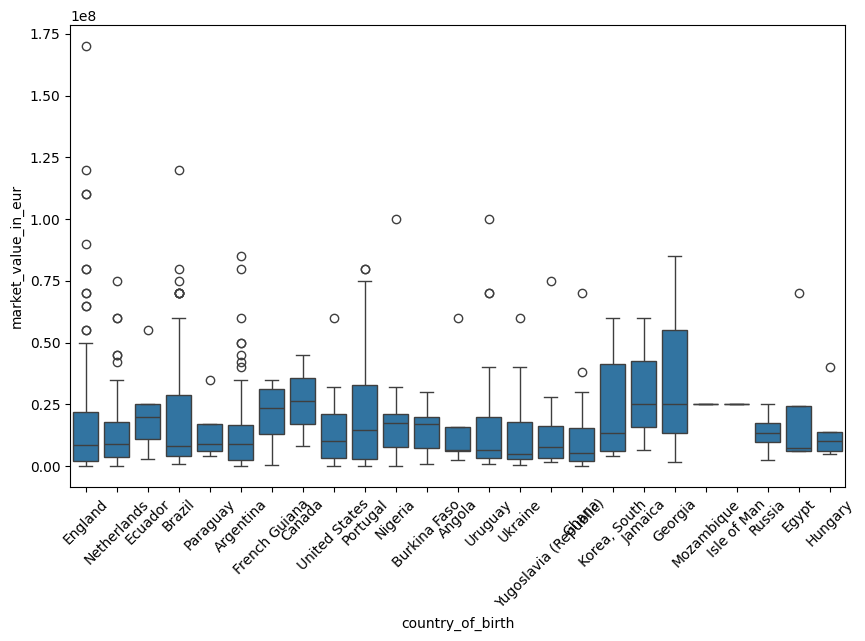

In [21]:
# Group by country of birth and get the average market value
country_market_values = df_features.groupby('country_of_birth')['market_value_in_eur'].mean().sort_values(ascending=False)

# Take the top N countries
top_countries = country_market_values.head(25)  # Adjust N as needed

# Filter the original DataFrame to include only the top N countries
top_countries_df = df_features[df_features['country_of_birth'].isin(top_countries.index)]

# Now plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='country_of_birth', y='market_value_in_eur', data=top_countries_df)
plt.xticks(rotation=45)
plt.show()

Very random and it seems like country of birth is wrong. Dropping column...

In [22]:
df_features = df_features.drop(columns=["country_of_birth", "country_of_citizenship"])

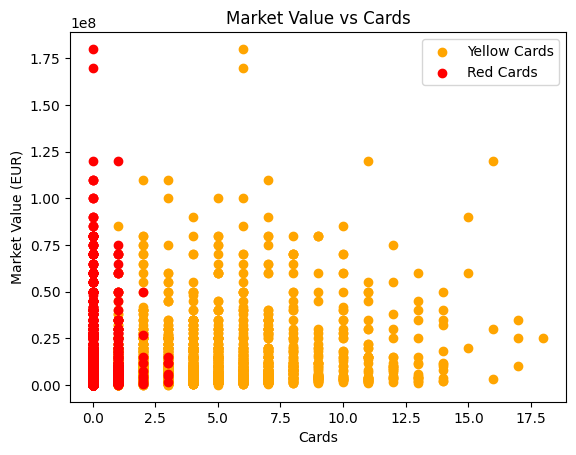

In [23]:
plt.scatter(df_features['yellow_cards'], df_features['market_value_in_eur'], label='Yellow Cards', color='orange')
plt.scatter(df_features['red_cards'], df_features['market_value_in_eur'], label='Red Cards', color='red')
plt.title('Market Value vs Cards')
plt.xlabel('Cards')
plt.ylabel('Market Value (EUR)')
plt.legend()
plt.show()

Market value seems to be negatively correlated with many red and yellow cards. Drop yellow cards but keep red.

In [24]:
df_features

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,player_name,position,foot,height_in_cm,age,months_left,own_goals,opponent_goals,is_win,clean_sheets
0,3333,2022-11-03,2000000,1237,GB1,3,0,0,2,1238,James Milner,Midfield,right,175.0,37.0,13,98,66,23,15
1,43530,2022-11-03,1500000,1237,GB1,0,0,3,1,759,Adam Lallana,Midfield,both,172.0,35.0,13,98,66,23,15
2,67063,2022-11-03,8000000,1237,GB1,0,0,7,3,2053,Danny Welbeck,Attack,right,185.0,33.0,13,98,66,23,15
3,73564,2023-03-16,1000000,1237,GB1,1,0,0,1,1890,Jason Steele,Goalkeeper,right,188.0,33.0,37,98,66,23,15
4,82873,2022-11-03,8000000,1237,GB1,6,0,8,10,3762,Pascal Groß,Midfield,right,181.0,32.0,25,98,66,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,350,GB1,0,0,0,0,65,Cameron Archer,Attack,right,175.0,22.0,49,12,10,4,2
2711,546712,2022-11-14,3500000,350,GB1,3,0,2,1,869,Anis Slimane,Midfield,both,188.0,22.0,37,12,10,4,2
2712,554251,2023-03-27,3500000,350,GB1,1,0,1,1,1716,Yasser Larouci,Defender,left,176.0,22.0,13,12,10,4,2
2713,663581,2022-11-07,7000000,350,GB1,12,0,1,1,2665,Vini Souza,Midfield,right,187.0,24.0,49,12,10,4,2


/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


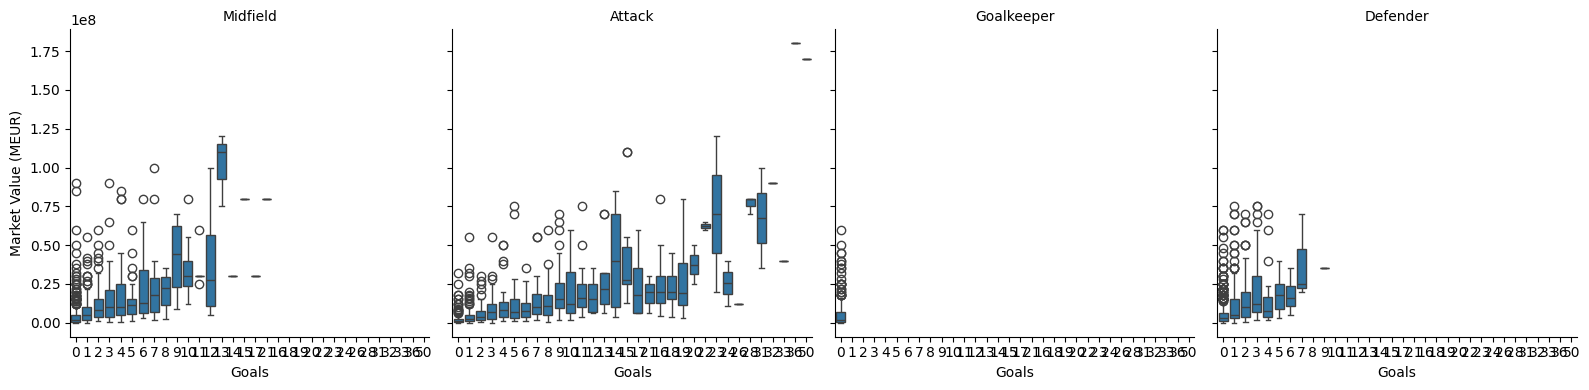

In [25]:
# Create separate box plots for market value against goals for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Goals", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Goals is, obviousley, correlated with market value, even for defenders it seems.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


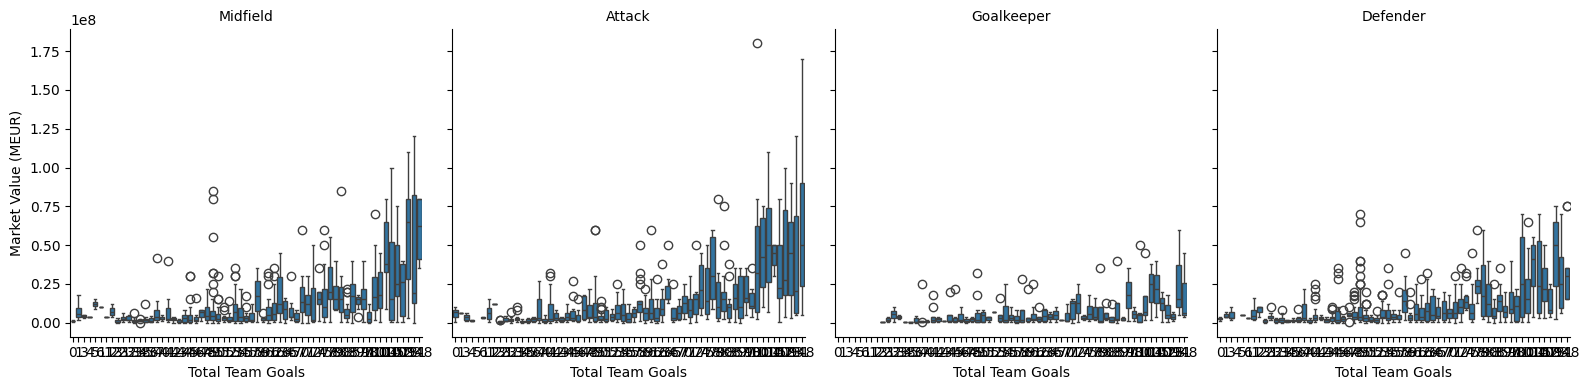

In [26]:
# Create separate box plots for market value against total team goals for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "own_goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Total Team Goals", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Total team goals also affects player price. We believe this attribute is catching player performances up until the second to last pass before a goal, therefore is affects midfielders the same way it affects attackers. The variation is not as high with defenders, but the trend seems to be positive nonetheless.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


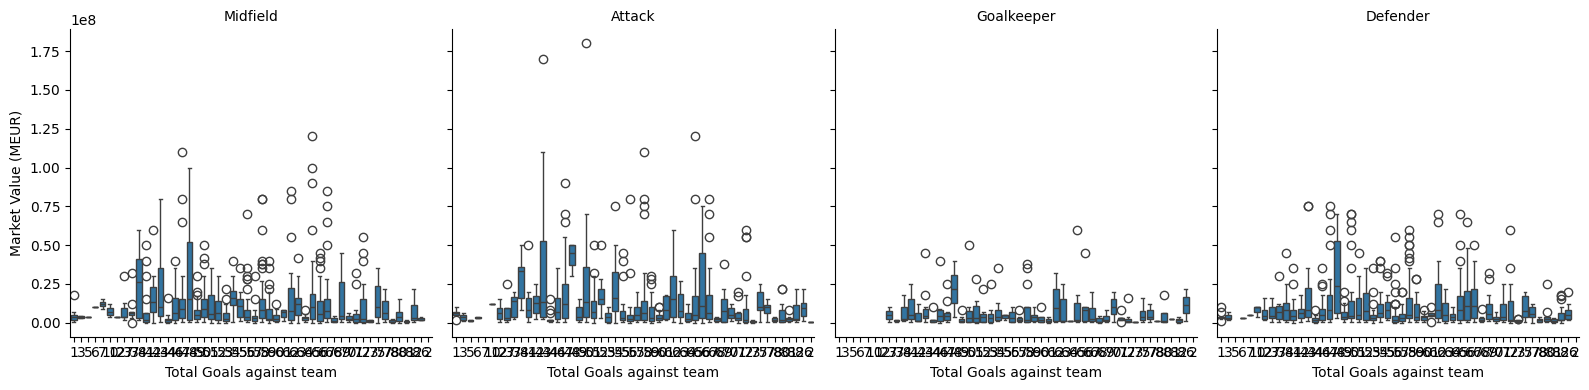

In [27]:
# Create separate box plots for market value against total goals scored against the team for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "opponent_goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Total Goals against team", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Goals scored against the team was thought to have large impact on player valuations, in particular goalkeepers and defenders. Surprisingly, there is not a clear trend of how it affects market value of the players. We keep it for now until further analysis are done.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


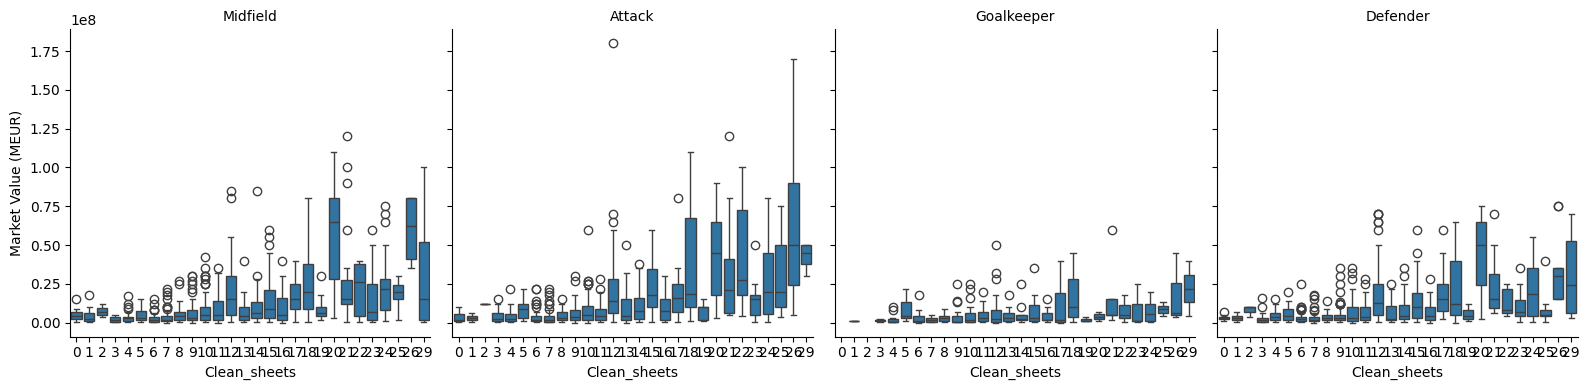

In [28]:
# Create separate box plots for market value against clean sheets for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "clean_sheets", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Clean_sheets", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

There seems to be a positive trend for value of goalkeepers and defenders with amount of clean_sheets, but also for attackers and midfielders; this probably has to do with that having a clean_sheet means there's a higher chance the match was won.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


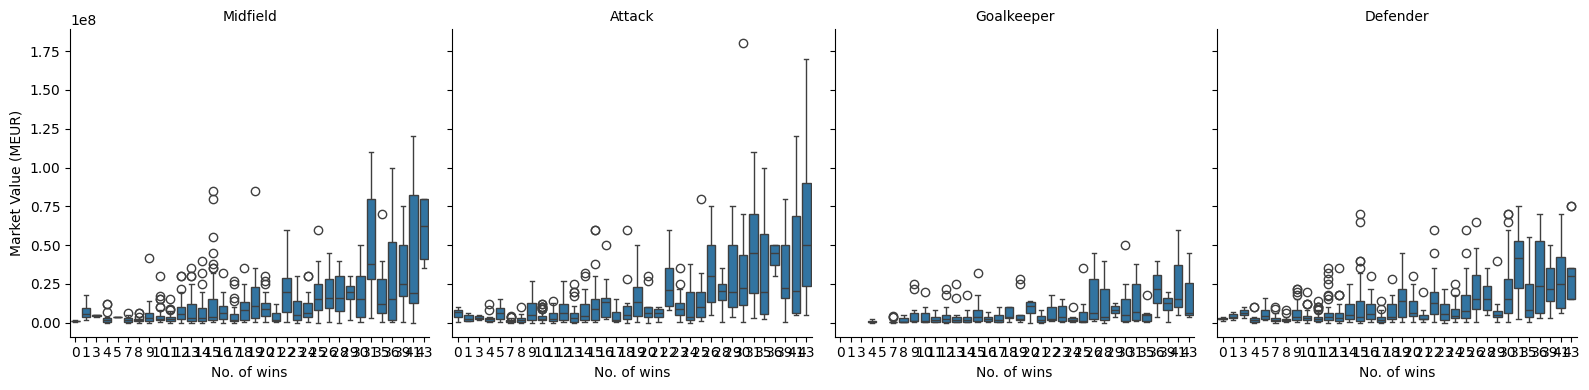

In [29]:
# Create separate box plots for market value against no. of wins for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "is_win", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("No. of wins", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

As thought, positive correlation for all positions.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


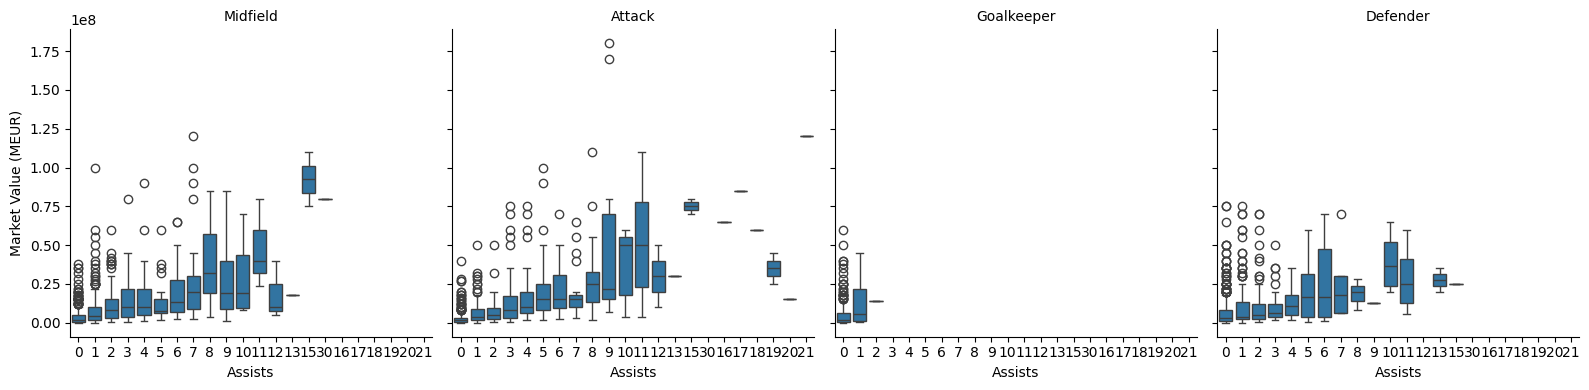

In [30]:
# Create separate box plots for market value against assists for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "assists", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Assists", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Same conclusion as for goals

<Figure size 1000x600 with 0 Axes>

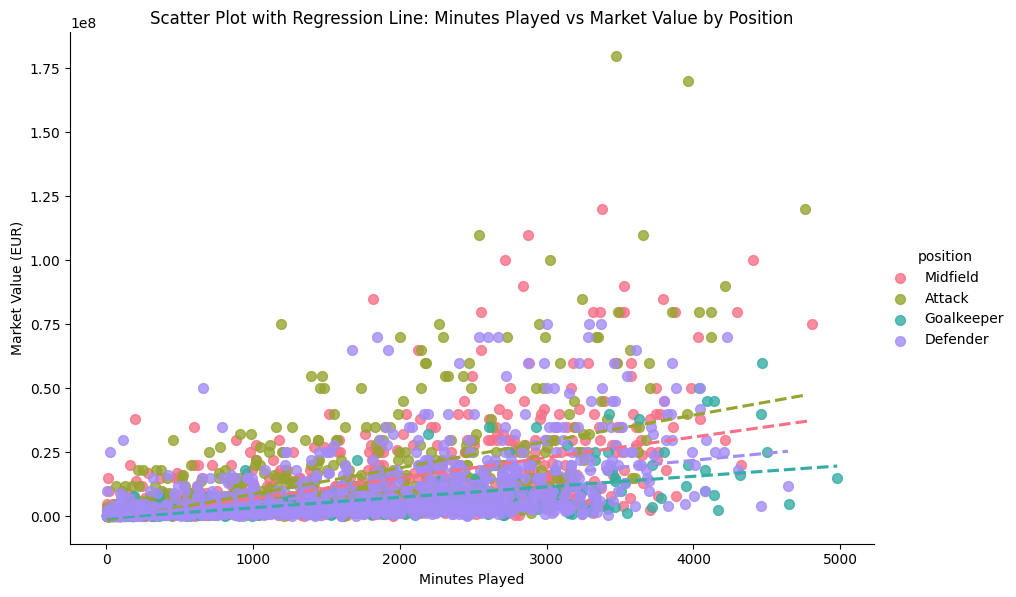

In [31]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='minutes_played', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Minutes Played vs Market Value by Position')
plt.xlabel('Minutes Played')
plt.ylabel('Market Value (EUR)')

plt.show()

As expected, positive correlation between minutes played and market value. However, most clear for Attackers and midfields

<Figure size 1000x600 with 0 Axes>

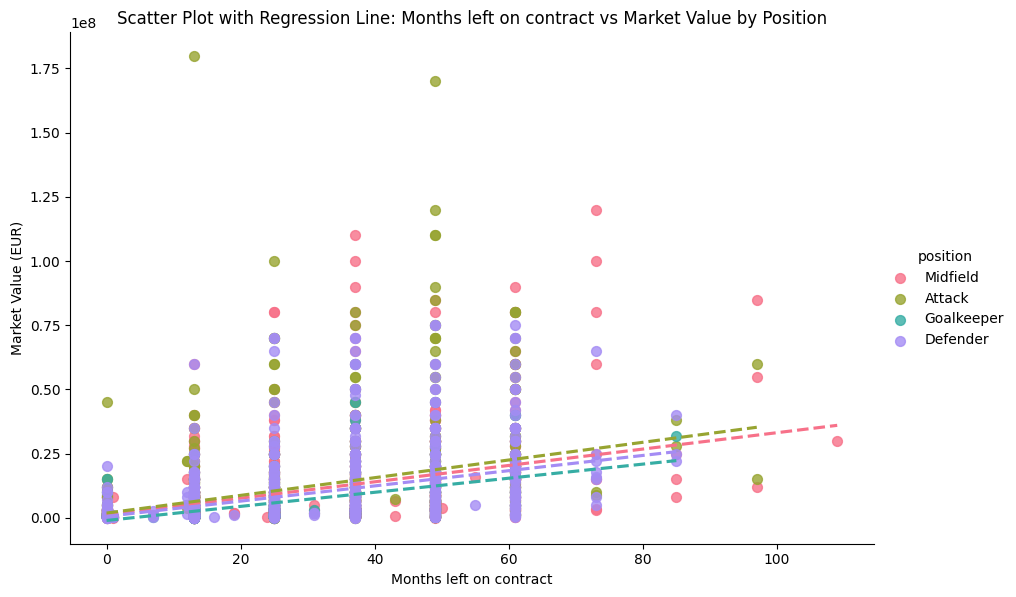

In [32]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='months_left', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Months left on contract vs Market Value by Position')
plt.xlabel('Months left on contract')
plt.ylabel('Market Value (EUR)')

plt.show()

Same as for minutes played

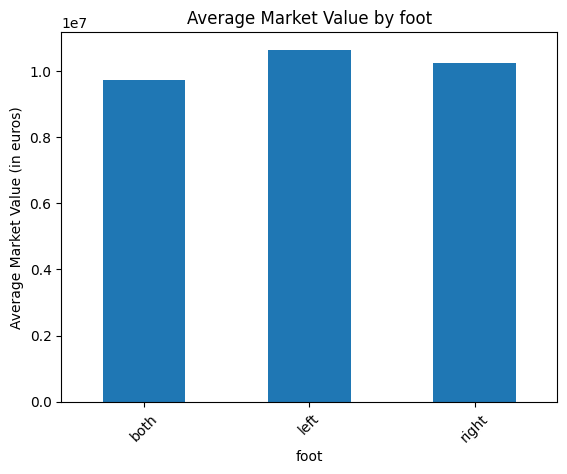

In [33]:
grouped_data = df_features.groupby('foot')['market_value_in_eur'].mean()

# Plotting
grouped_data.plot(kind='bar')
plt.title('Average Market Value by foot')
plt.xlabel('foot')
plt.ylabel('Average Market Value (in euros)')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability
plt.show()

No actual difference, dropping columns?

In [34]:
df_features = df_features.drop(columns=['foot'])

Text(39.956522955246925, 0.5, 'Market Value (EUR)')

<Figure size 1000x600 with 0 Axes>

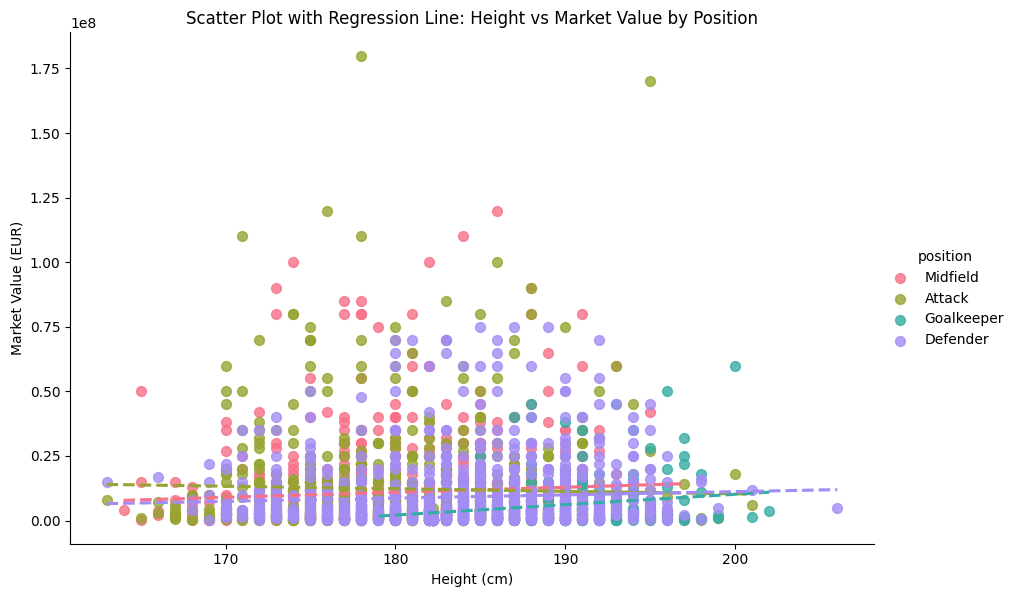

In [35]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='height_in_cm', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Height vs Market Value by Position')
plt.xlabel('Height (cm)')
plt.ylabel('Market Value (EUR)')

3/4 trends seem to be positive. We keep the feature for now.

Text(39.956522955246925, 0.5, 'Market Value (EUR)')

<Figure size 1000x600 with 0 Axes>

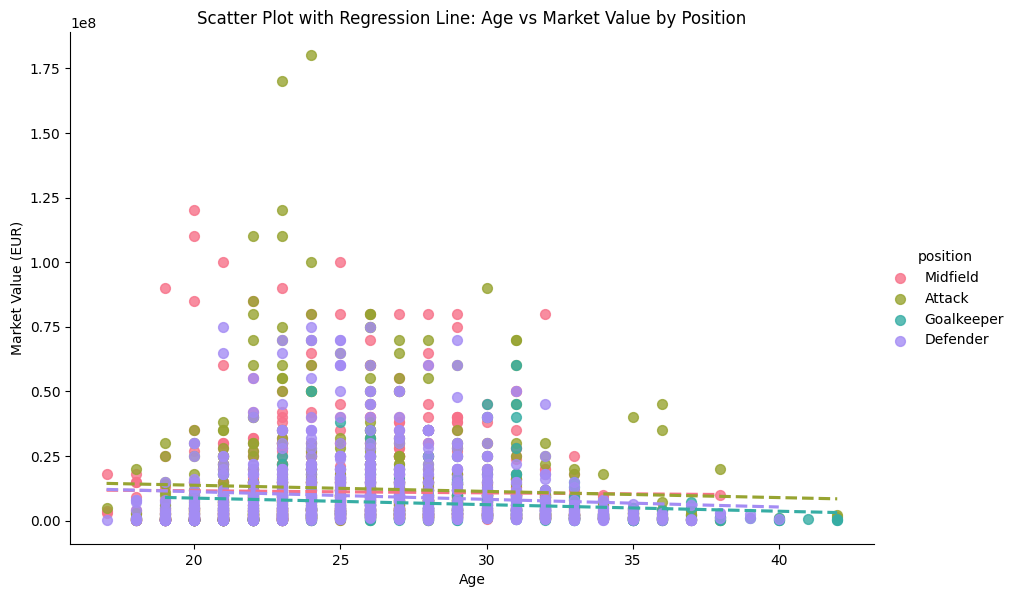

In [36]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='age', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Age vs Market Value by Position')
plt.xlabel('Age')
plt.ylabel('Market Value (EUR)')

A players value drops with age. 

In [37]:
df_numerical = df_features.drop(columns=['player_id', 'current_club_id', ])

df_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
market_value_in_eur,2714.0,1.033428e+07,1.558741e+07,25000.0,1500000.00,4000000.0,12000000.00,180000000.0
yellow_cards,2714.0,3.198968e+00,3.169180e+00,0.0,1.00,2.0,5.00,18.0
red_cards,2714.0,9.174650e-02,3.224921e-01,0.0,0.00,0.0,0.00,3.0
goals,2714.0,2.231761e+00,3.977416e+00,0.0,0.00,1.0,3.00,50.0
assists,2714.0,1.726234e+00,2.632104e+00,0.0,0.00,1.0,2.00,30.0
minutes_played,2714.0,1.544395e+03,1.132957e+03,1.0,516.75,1467.0,2438.25,4980.0
height_in_cm,2714.0,1.826840e+02,6.662400e+00,163.0,178.00,183.0,187.75,206.0
age,2714.0,2.646942e+01,4.647071e+00,17.0,23.00,26.0,30.00,42.0
months_left,2714.0,2.961312e+01,1.798271e+01,0.0,13.00,25.0,37.00,109.0
own_goals,2714.0,6.083640e+01,2.489877e+01,0.0,45.00,55.0,74.00,148.0


Market Value in EUR: This shows the market value of players in euros. The average value is about 10.33 million euros, with a standard deviation of 15.59 million euros, indicating significant variability. The minimum value is 25,000 euros, and the maximum is 180 million euros. The 25th percentile is 1.5 million euros, the median is 4 million euros, and the 75th percentile is 12 million euros. This wide range suggests a diverse group of players, from relatively unknown to superstars.

Yellow Cards: The average number of yellow cards per player is around 3.2, with a standard deviation of about 3.17, suggesting moderate variability. The maximum number of yellow cards received by a player is 18.

Red Cards: Players, on average, have received about 0.09 red cards, indicating that red cards are rare events. The maximum is 3 red cards per player.

Goals: The average number of goals scored per player is approximately 2.23, with a high standard deviation of 3.98, indicating a wide range in goal-scoring abilities. The maximum number of goals scored by a player is 50.

Assists: Players have made an average of about 1.73 assists, with a standard deviation of 2.63, showing significant variability. The maximum number of assists is 30.

Minutes Played: On average, players have played about 1544 minutes, with a standard deviation of 1133 minutes. This large standard deviation suggests a wide range in playing time among players.

Height in cm: The average height of the players is approximately 182.68 cm, with a standard deviation of 6.66 cm. This indicates a typical variation in height for athletes.

Age: The average age is about 26.47 years, with a standard deviation of 4.65 years, showing a typical age range for professional athletes.

Months Left: This likely refers to the remaining duration of players' contracts. The average is about 29.54 months, with a standard deviation of 17.93 months.

Own Goals: This column might contain incorrect data or might be mislabeled, as the average of 60.84 with a standard deviation of 24.90 doesn't seem to align with typical soccer statistics for own goals.

Opponent Goals: This also seems unusual for an individual player's statistic and might be mislabeled or incorrectly calculated. The average is around 56.87 with a standard deviation of 13.96.

Is Win: This could refer to the number of matches won by the player's team. The average is around 16.99 wins, with a standard deviation of 8.79.

Clean Sheets: This is typically a statistic for goalkeepers, indicating games without conceding a goal. The average is around 11.66, with a standard deviation of 5.81.

Overall, this dataset provides a comprehensive overview of various performance metrics for soccer players, although some columns (like own goals and opponent goals) might need clarification or correction.

In [38]:
df_features = df_features.drop(columns=['current_club_id'])

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `

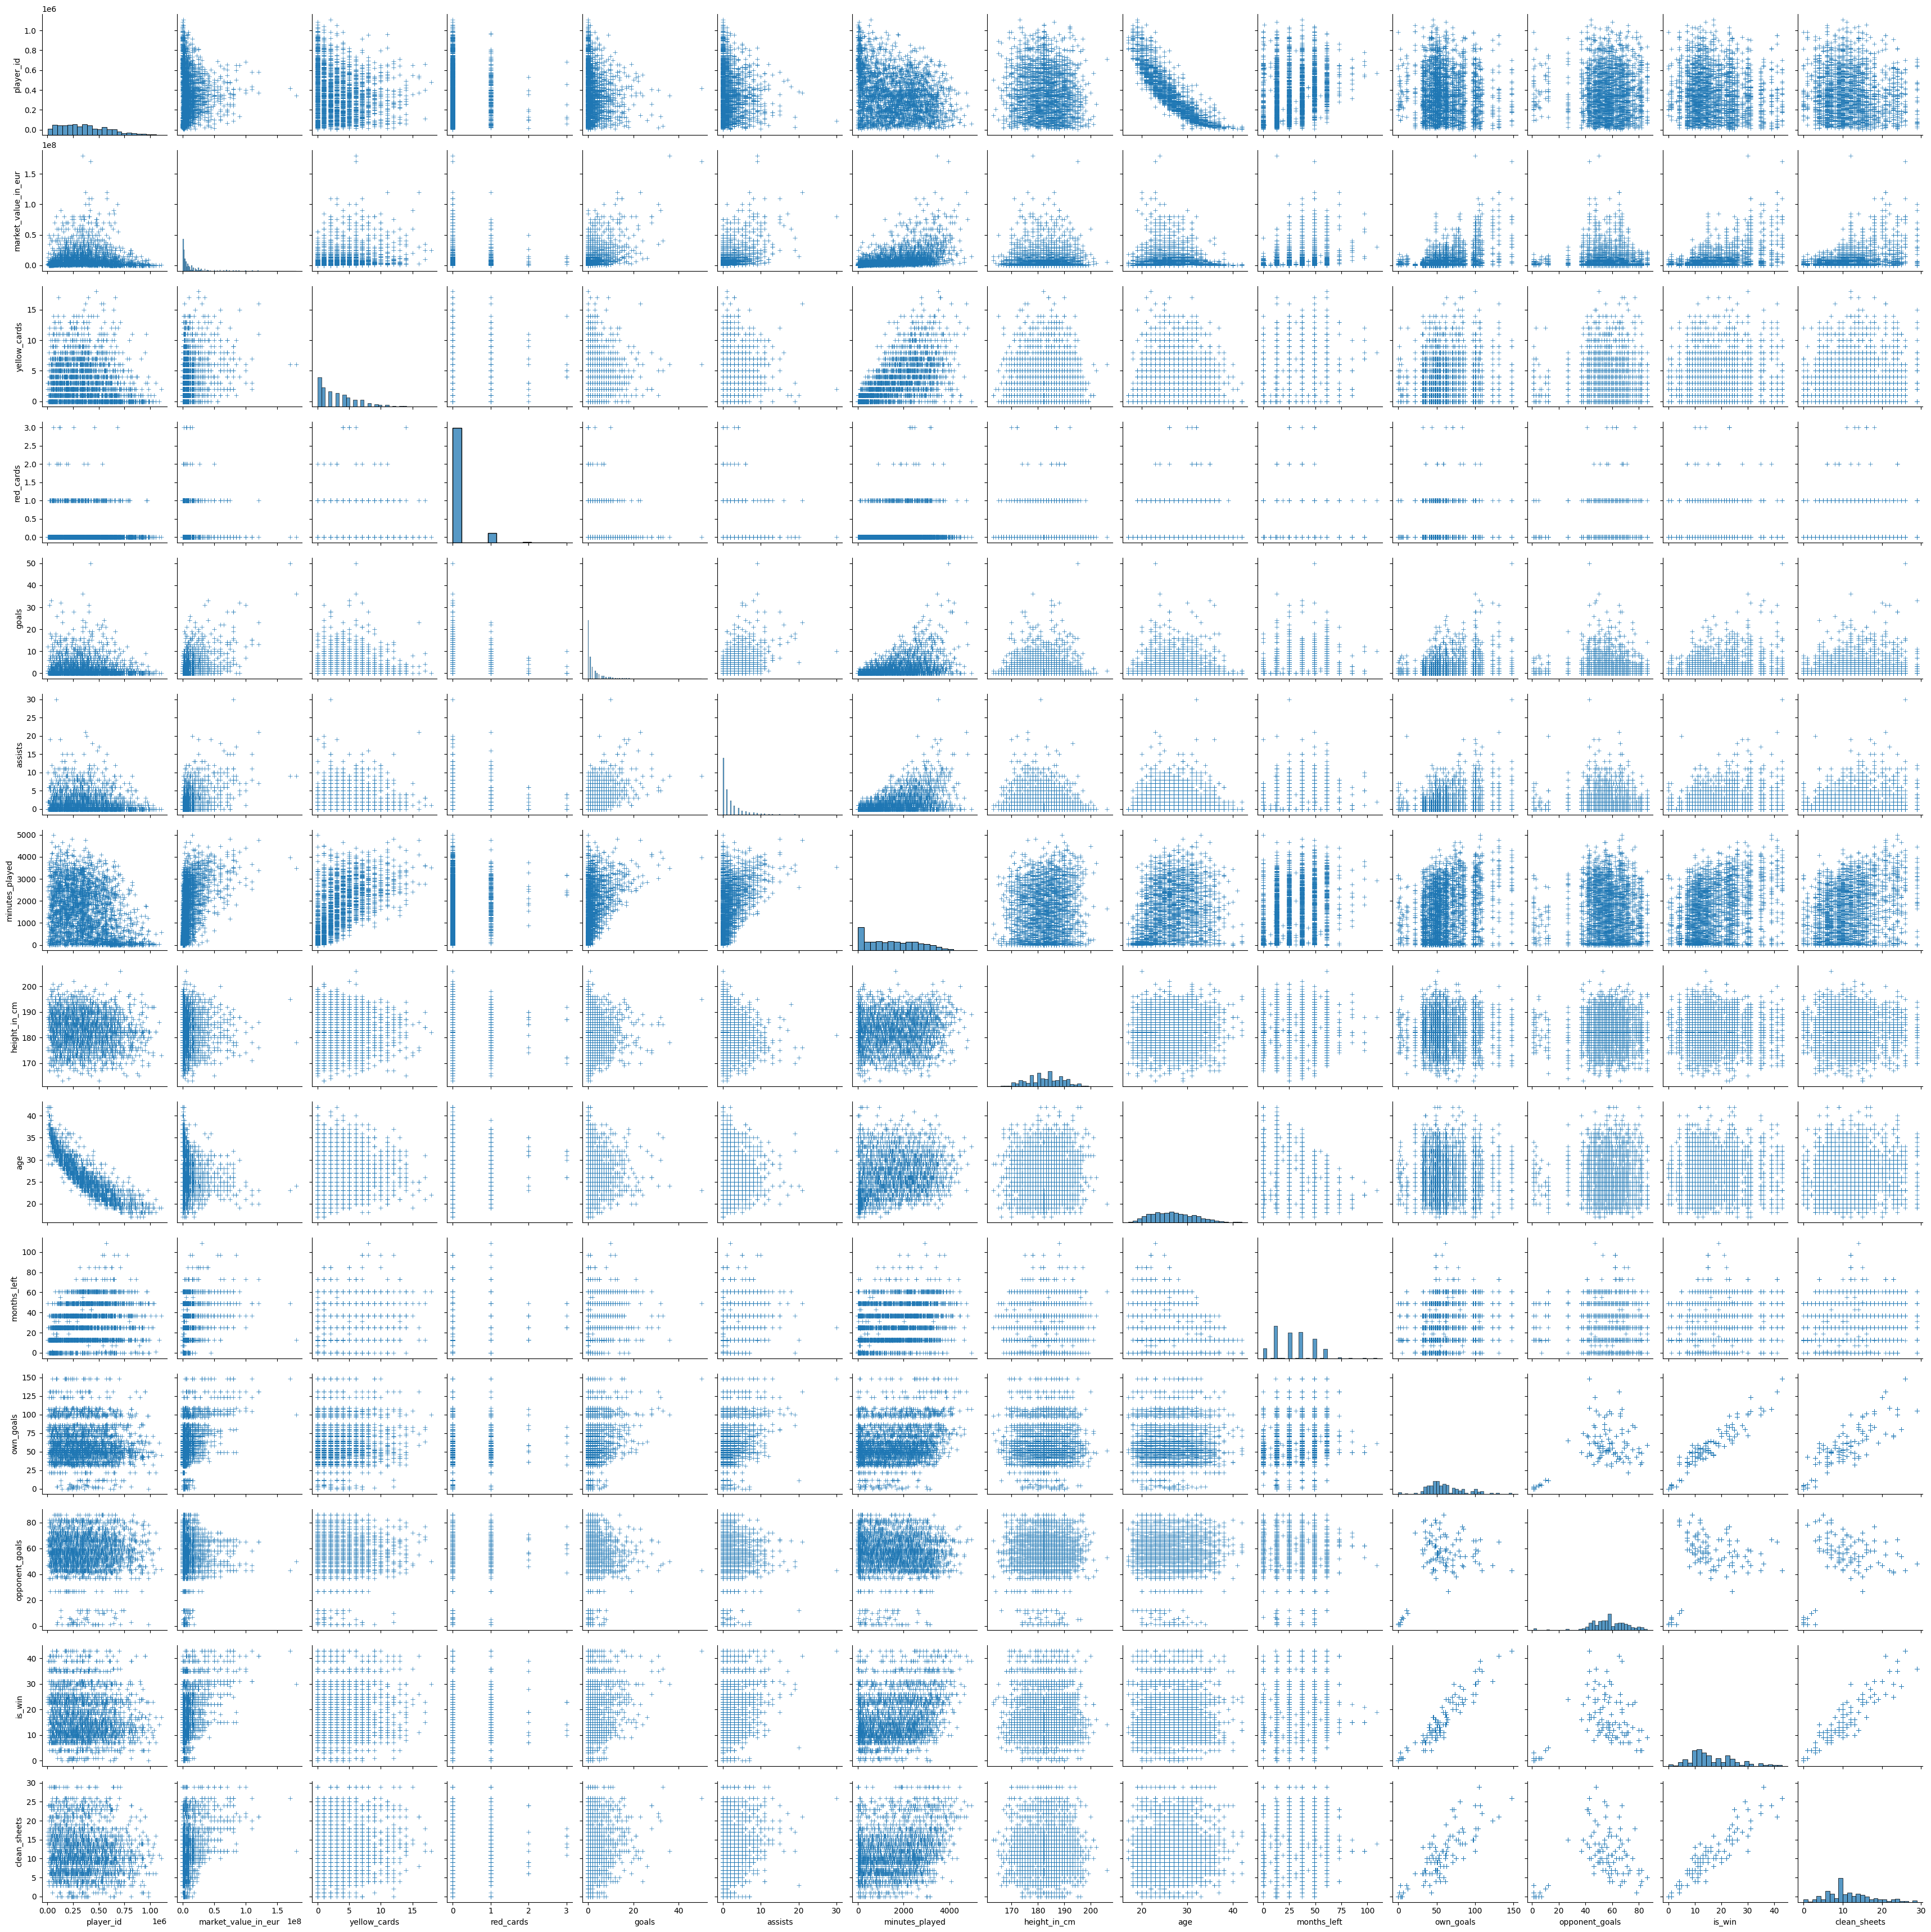

In [39]:

g = sns.pairplot(df_features, markers='+', palette="deep")
plt.show()

In [40]:
df_features

,player_id,date,market_value_in_eur,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,position,height_in_cm,age,months_left,own_goals,opponent_goals,is_win,clean_sheets
0,3333,2022-11-03,2000000,GB1,3,0,0,2,1238,Midfield,175.0,37.0,13,98,66,23,15
1,43530,2022-11-03,1500000,GB1,0,0,3,1,759,Midfield,172.0,35.0,13,98,66,23,15
2,67063,2022-11-03,8000000,GB1,0,0,7,3,2053,Attack,185.0,33.0,13,98,66,23,15
3,73564,2023-03-16,1000000,GB1,1,0,0,1,1890,Goalkeeper,188.0,33.0,37,98,66,23,15
4,82873,2022-11-03,8000000,GB1,6,0,8,10,3762,Midfield,181.0,32.0,25,98,66,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,GB1,0,0,0,0,65,Attack,175.0,22.0,49,12,10,4,2
2711,546712,2022-11-14,3500000,GB1,3,0,2,1,869,Midfield,188.0,22.0,37,12,10,4,2
2712,554251,2023-03-27,3500000,GB1,1,0,1,1,1716,Defender,176.0,22.0,13,12,10,4,2
2713,663581,2022-11-07,7000000,GB1,12,0,1,1,2665,Midfield,187.0,24.0,49,12,10,4,2


In [41]:
#Turn categorical feature into numerical
df_features = pd.get_dummies(df_features, columns=['player_club_domestic_competition_id', 'position', ], prefix=['League', 'position'])



<Axes: >

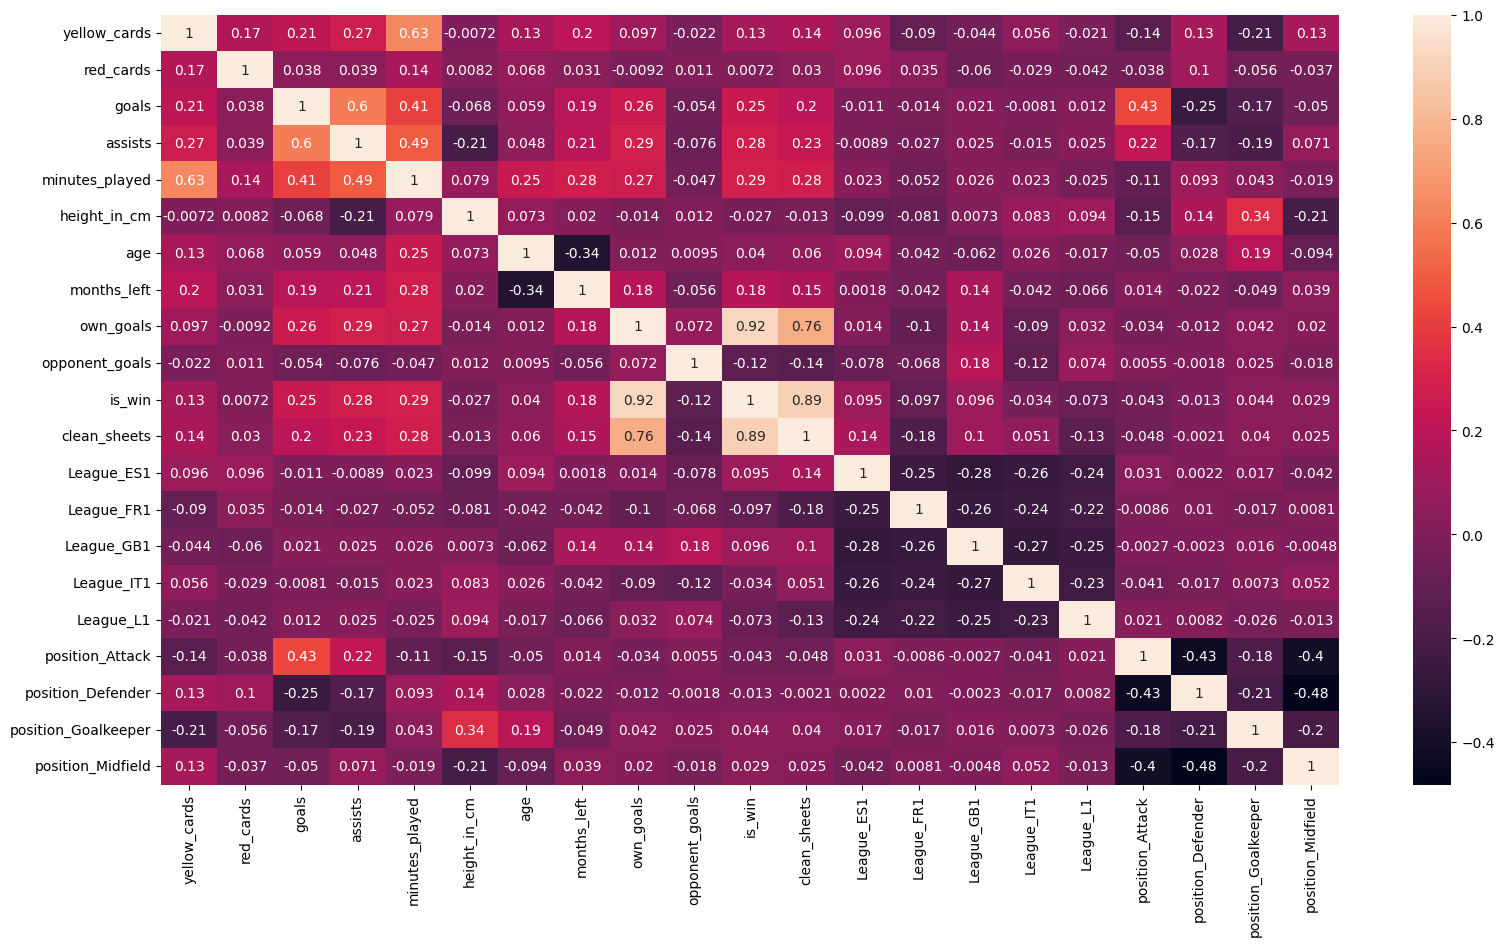

In [42]:
# ploting heatmap
df_featuresNoTarget = df_features.drop(columns=['market_value_in_eur', 'player_id', 'date'])

plt.figure(figsize=[19,10])
sns.heatmap(df_featuresNoTarget.corr(),annot=True)

Very high correlation between is_win with own_goals and clean_sheets. Drop is_win.

In [43]:
df_features = df_features.drop(columns='is_win')

In [44]:
df_features

,player_id,date,market_value_in_eur,yellow_cards,red_cards,goals,assists,minutes_played,height_in_cm,age,...,clean_sheets,League_ES1,League_FR1,League_GB1,League_IT1,League_L1,position_Attack,position_Defender,position_Goalkeeper,position_Midfield
0,3333,2022-11-03,2000000,3,0,0,2,1238,175.0,37.0,...,15,False,False,True,False,False,False,False,False,True
1,43530,2022-11-03,1500000,0,0,3,1,759,172.0,35.0,...,15,False,False,True,False,False,False,False,False,True
2,67063,2022-11-03,8000000,0,0,7,3,2053,185.0,33.0,...,15,False,False,True,False,False,True,False,False,False
3,73564,2023-03-16,1000000,1,0,0,1,1890,188.0,33.0,...,15,False,False,True,False,False,False,False,True,False
4,82873,2022-11-03,8000000,6,0,8,10,3762,181.0,32.0,...,15,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,0,0,0,0,65,175.0,22.0,...,2,False,False,True,False,False,True,False,False,False
2711,546712,2022-11-14,3500000,3,0,2,1,869,188.0,22.0,...,2,False,False,True,False,False,False,False,False,True
2712,554251,2023-03-27,3500000,1,0,1,1,1716,176.0,22.0,...,2,False,False,True,False,False,False,True,False,False
2713,663581,2022-11-07,7000000,12,0,1,1,2665,187.0,24.0,...,2,False,False,True,False,False,False,False,False,True


In [45]:
import hopsworks

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [47]:
valuation_fs = fs.get_or_create_feature_group(
    name="valuationdataset",
    version=1,
    primary_key=['player_id', 'date'],
    description = 'Feature group consisting of data for valuation of football players')

valuation_fs.insert(df_features)

Uploading Dataframe: 100.00% |██████████| Rows 2714/2714 | Elapsed Time: 00:07 | Remaining Time: 00:00


Launching job: valuationdataset_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/224406/jobs/named/valuationdataset_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fed96097b80>, None)